In [19]:
# Import libraries
%load_ext autoreload
%autoreload 2

from pulse_lib.pulse_program import *
import pickle

from qick import *
import Pyro4
%pylab inline

# Pyro communicates with board
Pyro4.config.SERIALIZER = "pickle"
Pyro4.config.PICKLE_PROTOCOL_VERSION=4

# Static IP proxy
ns_host = "192.168.2.99"
ns_port = 8888
proxy_name = "myqick"

# QICK object
ns = Pyro4.locateNS(host=ns_host, port=ns_port)
soc = Pyro4.Proxy(ns.lookup(proxy_name))
soccfg = QickConfig(soc.get_cfg())
print(soccfg)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib

QICK configuration:

	Board: RFSoC4x2

	Software version: 0.2.267
	Firmware timestamp: Wed Sep  6 18:49:29 2023

	Global clocks (MHz): tProcessor 409.600, RF reference 491.520

	2 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 0, blk 0 is DAC_B
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 2, blk 0 is DAC_A

	2 readout channels:
	0:	axis_readout_v2 - configured by PYNQ
		fs=4423.680 MHz, decimated=552.960 MHz, 32-bit DDS, range=4423.680 MHz
		maxlen 16384 accumulated, 1024 decimated (1.852 us)
		triggered by output 7, pin 14, feedback

In [20]:
# Import dictionary of sequences from pickle file
# with open('pulse_sequences/Sequence_ch1_ch2_mw.pickle', 'rb') as handle:
#     imported_sequences = pickle.load(handle)

# for key, value in imported_sequences.items():
#     print(key, value)

In [21]:
imported_sequences = {}
imported_sequences["MW"] = [(10000, 1.0, 0.2, 0)]
imported_sequences["DIG"] = [(10000, 1)]

pulse_sequences = PulseProgram(imported_sequences,
                              ch_map = {"DAC_A":"MW",  "DAC_B":"MW", "DIG_0":"DIG"},
                              delays = {"DAC_A":0,   "DAC_B":0,  "DIG_0":0},
                              gains  = {"DAC_A":20000, "DAC_B":20000},
                              )

----- DAC A -----
ch_type: DAC
ch_index: 1
delay: 0
gain: 20000
lengths: [10.0]
times: [0.0]
amps: [1.0]
freqs: [200.0]
phases: [0]
num_pulses: 1
duration: 10.0
----- DAC B -----
ch_type: DAC
ch_index: 0
delay: 0
gain: 20000
lengths: [10.0]
times: [0.0]
amps: [1.0]
freqs: [200.0]
phases: [0]
num_pulses: 1
duration: 10.0
----- DIG 0 ------
ch_type: DIG
ch_index: 0
delay: 0
lengths: [10.0]
times: [0.0]
num_pulses: 1
duration: 10.0
----- End time: 10.0 -----


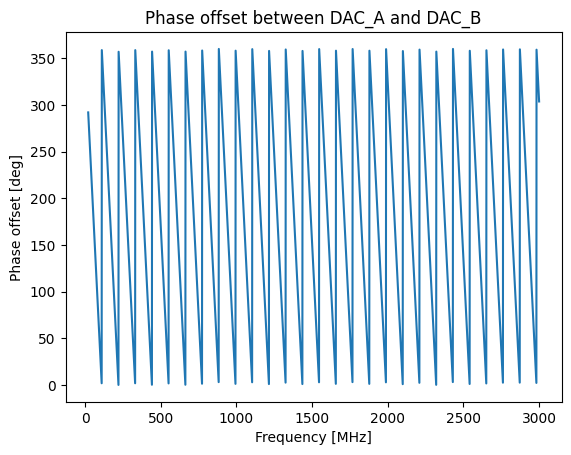

In [22]:
with open('pickles/calibrate_phase.pickle', 'rb') as handle:
    delta_phis = pickle.load(handle)

x,y = [], []
for key, value in delta_phis.items():
    x.append(key)
    y.append(value[0])

plt.plot(x,y)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Phase offset [deg]")
plt.title("Phase offset between DAC_A and DAC_B");

In [23]:
prog = QickProgram(soccfg)
pulse_sequences.generate_asm(prog, delta_phis, reps=1000000)
prog.config_all(soc)
soc.tproc.start() 
# print(prog)